In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import uniform
from sklearn import datasets, neighbors, linear_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import csv

import warnings
warnings.filterwarnings('ignore')

# get dataframe for training and testing data with column names inputted
train_data = pd.read_csv('TrainingDataMulti.csv', header=None)
test_data = pd.read_csv('TestingDataMulti.csv', header=None)

# Split the training data into data (column 1-128 as X) and target value (column 129 as Y), with all the rows selected
X = train_data.iloc[:,:-1]
Y = train_data.iloc[:,-1:]
# print(X_train.shape, Y_train.shape)

# Randomly shuffle dataframe of train data rows to give better representation in accuracy of the model
#Split the training data into training and testing part by a ratio
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.9, random_state=0, stratify = Y)

# Oversampling the training data to make it balanced
# from imblearn.over_sampling import SMOTE
# oversample = SMOTE()
# X_train, Y_train = oversample.fit_resample(X_train, Y_train)

# Y_train_df = pd.DataFrame(Y_train)
# Y_train_df.value_counts()

# Shows the data is high correlation 
# corr_matrix = X_train.corr()
# print(corr_matrix[1].sort_values(ascending=False))

In [76]:
# Build random forest classifier model, balanced the subsampling data to improve accuracy
model = RandomForestClassifier( random_state=0, class_weight="balanced_subsample")

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, Y_train)

model.fit(X_train, Y_train)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [77]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [79]:
# Use the best hyperparameter for building rf model
model = RandomForestClassifier( n_estimators=400, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', bootstrap=False, random_state=0, class_weight="balanced_subsample")
model.fit(X_train, Y_train)

# Predict model result of training and testing data for accuracy calculation
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

Crossval f1 score (5 folds):  [0.97283951 0.96358025 0.97222222 0.97160494 0.96851852]
Average crossval score (accuracy):  0.9697530864197532
Training Score (f1 macro):  1.0
Testing Score (f1 macro):  0.9642189209076625


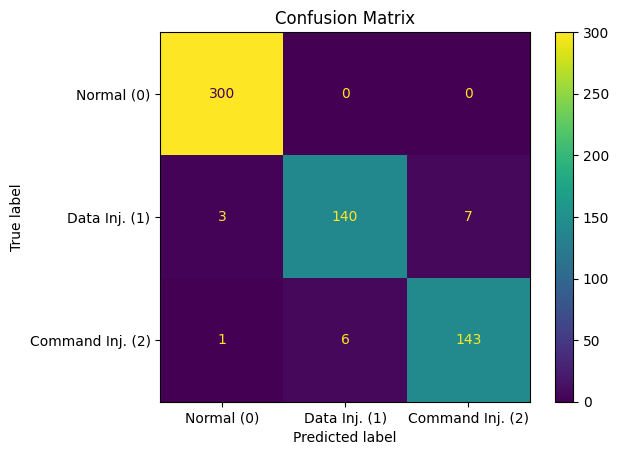

In [80]:
# Print results (cross validation score, f1_score, confusion matrix)
# Cross validation f1 score of the data
# 5 folds selected
kfold = KFold(n_splits=5, random_state=0, shuffle=True)
results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')

print("Crossval f1 score (5 folds): ", results)
avg_score = np.mean(results)
print("Average crossval score (accuracy): ", avg_score)

# Get training score and testing score
print ("Training Score (f1 macro): ",f1_score(Y_train, pred_train, average='macro'))
print ("Testing Score (f1 macro): " ,f1_score(Y_test, pred_test, average='macro'))

# Get confusion matrix
cm = confusion_matrix(Y_test, pred_test, labels= model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.title('Confusion Matrix')
tick_marks = np.arange(3)
plt.xticks(tick_marks, ['Normal (0)', 'Data Inj. (1)', 'Command Inj. (2)'])
plt.yticks(tick_marks, ['Normal (0)', 'Data Inj. (1)', 'Command Inj. (2)'])
plt.show()

In [81]:
# Get predict result of test data from TestingDataBinary
output_label = model.predict(test_data)
print(output_label)

# Create dataframe for the label
output_df = pd.DataFrame(output_label)
output_df.value_counts()

[2 2 2 2 2 2 1 1 2 2 2 1 1 1 1 1 2 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1
 1 2 1 1 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]


2    38
1    35
0    27
Name: count, dtype: int64

In [82]:
# Save it to an excel file
output_df.to_csv("TestingResultsMulti.csv", index=False, header=False) 